In [442]:
import pandas as pd
import numpy as np
import datetime
from darts import TimeSeries, concatenate
from darts.metrics import mape
import plotly.express as px
from copy import deepcopy
import warnings as wr
from darts.models import LinearRegressionModel, XGBModel, LightGBMModel, RandomForestModel, NaiveMovingAverage
from darts.dataprocessing.transformers import WindowTransformer, MissingValuesFiller, InvertibleMapper
from darts.dataprocessing.pipeline import Pipeline
from func_timeout import func_timeout, FunctionTimedOut
import optuna
import json
import re
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from etna.datasets.tsdataset import TSDataset, HierarchicalStructure
import asyncio
from datetime import datetime, timedelta
import uuid
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from itertools import product
import matplotlib.pyplot as plt
from kneed import KneeLocator
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from scipy import stats
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, remove_seasonality, remove_trend, plot_hist, stationarity_tests
from darts.utils.utils import SeasonalityMode

pd.options.plotting.backend = "plotly"

In [415]:
%matplotlib inline

In [ ]:
class ForecastManager:
    def __init__(self):
        self.sessions = {}
        self.cleanup_task = asyncio.create_task(self.cleanup_old_sessions())
    
    async def cleanup_old_sessions(self):
        """Очистка старых сессий каждые 5 минут"""
        while True:
            await asyncio.sleep(300)
            now = datetime.now()
            expired_sessions = [
                session_id for session_id, session_data in self.sessions.items()
                if now - session_data['last_activity'] > timedelta(hours=1)
            ]
            for session_id in expired_sessions:
                del self.sessions[session_id]
    
    def create_session(self, table_name: str, table_data: pd.DataFrame) -> str:
        """Создать новую сессию с таблицей"""
        session_id = str(uuid.uuid4())
        
        # Подготавливаем данные для формирования прогноза
        prepared_data = self._prepare_history_data(table_data.copy())
        
        self.sessions[session_id] = {
            'table_name': table_name,
            'original_data': prepared_data,
            'describe_table': None,
            'pipeline': [],  # Единый список для всех трансформаций
            'created_at': datetime.now(),
            'last_activity': datetime.now()
        }
        return session_id
    
    def _prepare_history_data(df: pd.Dataframe) -> pd.DataFrame:
        """Приводим данные к нужному формату"""
        df['segment'] = (
            df['Канал'].fillna('пропуск') + '_' + 
            df['Управленческая Линейка'].fillna('пропуск') + '_' + 
            df['Управленческое Наименование'].fillna('пропуск')
        )
        
        df = df.groupby(['segment', pd.Grouper(key='Дата', freq='M')], as_index=False)['Количество'].sum()

        df.rename(columns={'Дата':'timestamp', 'Количество':'target'}, inplace=True)
        
        return df
    
    def get_describe_table(df: pd.DataFrame) -> pd.DataFrame:
        """Формирует датафрейм со сводными данными и первичной классификацией временных рядов"""



In [451]:
df = pd.read_excel('history.xlsx')

In [452]:
df['segment'] = df['Канал'].fillna('пропуск') + '_' + df['Управленческая Линейка'].fillna('пропуск') + '_' + df['Управленческое Наименование'].fillna('пропуск')

In [453]:
df = df.groupby(['segment', pd.Grouper(key='Дата', freq='M')], as_index=False)['Количество'].sum()

C:\Users\Kruglov\AppData\Local\Temp\ipykernel_15508\2497279514.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52739 entries, 0 to 52738
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   segment     52739 non-null  object        
 1   Дата        52739 non-null  datetime64[ns]
 2   Количество  52739 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [454]:
df.rename(columns={'Дата':'timestamp', 'Количество':'target'}, inplace=True)

In [455]:
df['target'] = np.where(df['target'] < 0, 0, df['target'])

In [422]:
def classify_ts(row):
    if row['var'] == 0 or row['ts_length'] <= 6:
        return 'const'
    elif row['ts_length'] >= 12 and row['no_zero_length'] < 30:
        return 'perfect'
    elif row['no_zero_length'] >= 50:
        return 'croston'
    else:
        return 'naive_methods'

In [ ]:
def create_describe_table(df):
    describe_list = []

    for i in df['segment'].unique():
        print(i)
        segment_data = {}
        segment_data['segment'] = i
        ts = df[df['segment']==i]
        ts = TimeSeries.from_dataframe(ts.drop('segment', axis=1), time_col='timestamp', freq='M')
        end_time = ts.end_time()
        start_time = ts.start_time()
        longest_period = ts.longest_contiguous_slice().shape[0]
        ts_length = ts.shape[0]
        df_ts = ts.to_dataframe().fillna(0)
        zero_count = df_ts.isin([0]).sum().sum()
        var = round(df_ts.std().iloc[0], 2)
        
        segment_data['end_time'] = end_time
        segment_data['start_time'] = start_time
        segment_data['zero_count'] = zero_count
        segment_data['longest_period'] = longest_period
        segment_data['ts_length'] = ts_length
        segment_data['var'] = var
        
        describe_list.append(segment_data)

        df_describe = pd.DataFrame(data=describe_list)

        df_describe.fillna({'var': 0}, inplace=True)

        df_describe['no_zero_length'] = df_describe.apply(lambda row: 0 if (row['zero_count'] / row['ts_length'] * 100) == 0 else row['zero_count'] / row['ts_length'] * 100, axis=1)

        return df_describe


In [456]:
df = df[['timestamp', 'target', 'segment']]

In [457]:
df_describe = create_describe_table(df)

A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75


c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [464]:
def make_classification(df_describe, df):
    df_describe['ts_type'] = df_describe.apply(classify_ts, axis=1)

    df_class = df.merge(df_describe[['segment', 'ts_type']], on='segment', how='left')

    assert df.shape[0] == df_class.shape[0], "Размер датафрейма изменился"

    return df_describe, df_class

In [465]:
df_describe, df = make_classification(df_describe, df)

In [443]:
def extract_ts_stats(df, segment_col='segment', date_col='timestamp', value_col='target'):
    # Извлекаем все возможные признаки
    features = extract_features(
        df, 
        column_id=segment_col, 
        column_sort=date_col,
        column_value=value_col,
        impute_function=impute
        )
    
    y = df.groupby(segment_col)[value_col].mean()  # берем целевую переменную для каждого id

    features_filtered = select_features(features, y)

    return features_filtered
    

In [ ]:
def knee_method(stats_df, scaler, scaling=False, show_plot=False):
    if scaling:
        stats_df = scaler.fit_transform(stats_df)
    # Метод локтя
    inertia = []
    k_range = range(1, 15)  # пробуем от 1 до 14 кластеров

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(stats_df)
        inertia.append(kmeans.inertia_)

    kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow

    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia (Within-cluster sum of squares)')
        plt.title('Elbow Method for Optimal K')
        plt.grid(True)
        plt.axvline(x=optimal_k, color='red', linestyle='--', 
           label=f'Optimal K = {optimal_k}')
        plt.legend()
        plt.show()

    return optimal_k       

In [438]:
def make_clustering(df, df_describe, stats_df, scaler, k, scaling=False):
    # Кластеризация
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(stats_df)

    unique_clusters = np.unique(cluster_labels)

    # Создаем маппинг segment -> cluster
    segment_to_cluster = pd.Series(cluster_labels, index=stats_df.index, name='cluster')

    # Добавляем кластеры к основному датафрейму
    result_df = df.merge(segment_to_cluster, left_on='segment', right_index=True)

    result_describe = df_describe.merge(segment_to_cluster, left_on='segment', right_index=True)

    return result_df, result_describe, unique_clusters

In [441]:
def cluster_ts_visualisation(df, cluster):
    cluster_df = df[df['cluster'] == cluster]

    fig = px.line(
        cluster_df,
        x='timestamp',
        y='target',
        color='segment',
        title='Продажи по SKU',
        labels={'target': 'Продажи', 'date': 'Дата'},
        template='plotly_white'
    )

    fig.show()

In [193]:
def find_pacf_lags(series, segment, max_lags=12, alpha=0.05, method='ols'):

    
    pacf_values = pacf(series, nlags=max_lags, method=method)

    # Рассчитываем доверительные интервалы как в plot_pacf
    n = len(series)
    
    # Используем z-score для заданного alpha (двусторонний тест)
    z_score = stats.norm.ppf(1 - alpha/2)
    conf_int_bound = z_score / np.sqrt(n)

    lags = range(len(pacf_values))
    lower_bound = [-conf_int_bound] * len(pacf_values)
    upper_bound = [conf_int_bound] * len(pacf_values)


    
    pacf_df = pd.DataFrame({
        'lags': lags,
        'pacf': pacf_values,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'segment':segment,
        'lag_kind':'sign_pacf'
    })
    
    pacf_df['is_sign'] = (pacf_df['pacf'] > pacf_df['upper_bound']) | (pacf_df['pacf'] < pacf_df['lower_bound'])

    ts = TimeSeries.from_dataframe(series, freq='M')

    seasonal_list = []

    for i in range(2, max_lags):
        season_tuple = check_seasonality(ts, m=i, max_lag=max_lags)
        if season_tuple[0] == True:
            seasonal_list.append(season_tuple[1])

    seasonal_df = pd.DataFrame({
        'lags': seasonal_list,
        'segment':segment,
        'lag_kind':'cheack_seasonality',
        'is_sign':True
    })

    # Исключаем лаг 0 (он всегда равен 1 и всегда значим)
    sign_lags = pacf_df[pacf_df['is_sign'] & (pacf_df['lags'] > 0)]['lags'].tolist()

    result_df = pd.concat([pacf_df, seasonal_df])

    
    
    return sign_lags, result_df

In [200]:
lags_list = []

for i in second_cluster['segment'].unique():
    print(i)
    segment_df = second_cluster[second_cluster['segment'] == i]
    _, pacf_df = find_pacf_lags(segment_df[['timestamp', 'target']].set_index('timestamp'), i, max_lags=int(len(segment_df)/2)) 
    lags_list.append(pacf_df)

A2Z_внеш_РШ_РШ  Белое Брют 0,75
A2Z_внеш_РШ_РШ  Белое Полусладкое 0,75
АДКМ_4 воды_4 воды Виноградная  Питьевая вода 0,75
АДКМ_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
АДКМ_4 воды_4 воды газ  Питьевая вода 0,375
АДКМ_4 воды_4 воды газ  Питьевая вода 0,75
АДКМ_4 воды_4 воды негаз  Питьевая вода 0,375
АДКМ_4 воды_4 воды негаз  Питьевая вода 0,75
АДКМ_7 овощей_7 овощей  0,5
АДКМ_7 овощей_7 овощей  1,5
АДКМ_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Ананаса и Винограда  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Манго и Винограда  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Пино Нуар  Напиток газированный 0,375


c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АДКМ_Абрау Винонад_Абрау Винонад со вкусом Траминер  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Черешни и Винограда  Напиток газированный 0,375
АДКМ_Абрау Джуниор_Абрау Джуниор Золотое  Безалкогольное шампанское 0,75
АДКМ_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75
АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,25
АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,25
АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,75
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Сладкое 0,75
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,25
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Розовое Полусладкое 0,25
АДКМ_Абрау Спуманте_Абрау Спуманте  Белое Брют 0,75
АДКМ_Абрау Спуманте_Абрау Спуманте  Белое 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АДКМ_Абрау Эстейтс_Абрау Эстейтс Каберне Совиньон Белое Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Оранж Белое Сухое 0,75
АДКМ_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
АДКМ_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
АДКМ_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
АДКМ_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
АДКМ_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
АДКМ_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
АДКМ_Аперитив Абрау_Аперитив Абрау  0,7
АДКМ_ВВ_ВВ  Белое Сухое 0,75
АДКМ_ВВ_ВВ  Розовое Сухое 0,75
АДКМ_ВВ_ВВ Голубок Красное Сухое 0,75
АДКМ_ВВ_ВВ Каберне Красное Сухое 0,75
АДКМ_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
АДКМ_ВВ_ВВ Красностоп Розовое Сухое 0,75

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АДКМ_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сухой  Резервуарный 0,75
АДКМ_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник без сахара»  Напиток газир
АДКМ_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник»  Напиток газированный 0,3
АДКМ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG  "ДИКИЙ ВИНОГРАД" 0,45  На
АДКМ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "СЕВЕРНЫЕ ЯГОДЫ"
АДКМ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "ЯБЛОКО-БУЗИНА"
АДКМ_пропуск_C.C.S.M.T. РЛ ВИ ЗНМП сухое белое «Фрешенет Просекко DOC» 0,2 Сухое Белое 0,2 л.
АДКМ_пропуск_C.C.S.M.T. РЛ ВИ ЗНМП сухое белое «Фрешенет Просекко DOC» 0,75 Сухое Белое 0,75 л.
АДКМ_пропуск_CHATEAU COTES DE SAINT DANIEL  Сладкое 0,75
АДКМ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,02 л.
АДКМ_пропуск_HANDELSHOF Шнапс Лес

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АДКМ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Сухое Красное 0,75 л.
АДКМ_пропуск_Шато де Талю Блан Сухое Белое 0,375 л.
АДКМ_пропуск_Шато де Талю Блан Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Клере Сухое Розовое 0,75 л.
АДКМ_пропуск_Шато де Талю Розе Сухое розовое 0,75 л.
АДКМ_пропуск_Шато де Талю Руж Сухое Красное 0,375 л.
АДКМ_пропуск_Шато де Талю Руж Сухое Красное 0,75 л.
АДКМ_пропуск_Шато де Талю Совиньон Блан Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Шардоне Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Шираз Сухое Красное 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Совиньон Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Фран Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Красностоп Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Мерло Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Шираз Резерв" 0,75 л.
АДКМ_пропуск_ЯНОВА Кабер

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АТВ_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75
АТВ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,25
АТВ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
АТВ_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,25
АТВ_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,75
АТВ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25
АТВ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75
АТВ_Абрау Лайт стар_Абрау Лайт стар  Белое Сладкое 0,75
АТВ_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,25
АТВ_Абрау Лайт стар_Абрау Лайт стар  Розовое Полусладкое 0,25
АТВ_Абрау Спуманте_Абрау Спуманте  Белое Брют 0,75
АТВ_Абрау Спуманте_Абрау Спуманте  Белое Полусухое 0,75
АТВ_Абрау Спуманте_Абрау Спуманте  Розовое Брют 0,75
АТВ_Абрау Фиори_Абрау Фиори полусладкий Белое Резервуарный 0,75
АТВ_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75
АТВ_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
АТВ_Абрау Эстейтс_Абра

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АТВ_ВВ_ВВ Ассамбляж Белое Сухое 0,75
АТВ_ВВ_ВВ Голубок Красное Сухое 0,75
АТВ_ВВ_ВВ Каберне Красное Сухое 0,75
АТВ_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
АТВ_ВВ_ВВ Красностоп Розовое Сухое 0,75
АТВ_ВВ_ВВ Пухляковский Белое Сухое 0,75
АТВ_ВВ_ВВ Сибирьковый Белое Сухое 0,75
АТВ_ВВР_ВВР  Белое Сухое 0,75
АТВ_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
АТВ_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
АТВ_ВВР_ВВР Ркацители выдержаное в дубе Белое Сухое 0,75
АТВ_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
АТВ_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
АТВ_Ведерников Пет-Нат_Ведерников Пет-Нат Красностоп Красное Полусухое 0,75
АТВ_Ведерников Пет-Нат_Ведерников Пет-Нат Рислинг Белое Брют 0,75
АТВ_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75
АТВ_Ведерников игристое_Ведерников игристое Цимлянский Розовое Брют 0,75
АТВ_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АТВ_Дравиньи_Дравиньи  Розовое Брют 0,375
АТВ_Дравиньи_Дравиньи  Розовое Брют 0,75
АТВ_Дравиньи_Дравиньи П/У Белое Брют 0,75
АТВ_Дравиньи_Дравиньи П/У Розовое Брют 0,75
АТВ_Империал_Империал Винтаж Белое Брют 0,75
АТВ_Империал_Империал П/У  Розе Розовое Брют 0,75
АТВ_Империал_Империал П/У Винтаж Белое Брют 0,75
АТВ_Империал_Империал П/У Винтаж Белое Брют 1,5
АТВ_Империал_Империал П/У Винтаж Белое Брют 6
АТВ_Империал_Империал Розе Розовое Брют 0,75
АТВ_Коньяк 1870_Коньяк 1870 КВ 0,7
АТВ_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
АТВ_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
АТВ_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
АТВ_Коньяк Ширван_Коньяк Ширван П/У 0,7
АТВ_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
АТВ_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
АТВ_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
АТВ_Портв

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АТВ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG  "ДИКИЙ ВИНОГРАД" 0,45  На
АТВ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "СЕВЕРНЫЕ ЯГОДЫ"
АТВ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "ЯБЛОКО-БУЗИНА"
АТВ_пропуск_C.C.S.M.T. РЛ ВИ ЗНМП сухое белое «Фрешенет Просекко DOC» 0,75 Сухое Белое 0,75 л.
АТВ_пропуск_CPWCL Чанг-Юй Нобл Драгон 0,7 л.
АТВ_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,5 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Зеленое Яблоко 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Лесной Орех 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Малина 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Плодовое Ассорти 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Слива Мирабель желтая 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Терн 0,5 0,5 л.
АТВ_пропуск_ITUT Ирландский купажированный виски "Прокламэйшн" 0,7 л.
АТВ_пропуск_АЛ «Маунтен Иг

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

АТВ_пропуск_РЛ ВС ординарное белое сухое НИКОЛА БЕРГАЛЬО МИНАЙЯ ГАВИ ДОКГ ДЕЛЬ КОМУНЕ ДИ ГАВИ РОВЕРЕТО 0,75 л
АТВ_пропуск_Руж де Талю сухое красное 0,75 л
АТВ_пропуск_СББАШ "Рубин" Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ "Трезвая голова. Саперави" Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Адау Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Афа Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Каберне Совиньон Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Каберне Фран Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Красностоп  Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Красностоп Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Рислинг Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Сибирьковый + Пино Гри Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Трезвая голова. Ркацители Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Трезвая голова. Розовое  Сухое Розовое 0,75 л.
АТВ_пропуск_СОМЕЛЬЕ ГН Кубань Каберне Совиньон Резерв Сухое Красное 0,75 л.
АТВ_пропуск_СОМЕЛЬЕ Каберне Совиньон резерв 2009 Вилла Виктория Сухое Красное 0,75 л.
АТВ_пропуск_СОМЕЛЬЕ София Семи

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ЗАО_Дравиньи_Дравиньи  Белое Полусухое 0,75
ЗАО_Дравиньи_Дравиньи  Белое Экстра брют 0,75
ЗАО_Дравиньи_Дравиньи  Красное Полусладкое 0,75
ЗАО_Дравиньи_Дравиньи  Розовое Брют 0,375
ЗАО_Дравиньи_Дравиньи  Розовое Брют 0,75
ЗАО_Империал_Империал Винтаж Белое Брют 0,75
ЗАО_Империал_Империал П/У Винтаж Белое Брют 0,75
ЗАО_Империал_Империал П/У Винтаж Белое Брют 1,5
ЗАО_Империал_Империал Розе Розовое Брют 0,75
ЗАО_РШ_РШ  Белое Брют 0,2
ЗАО_РШ_РШ  Белое Брют 0,75
ЗАО_РШ_РШ  Белое Полусладкое 0,75
ЗАО_РШ_РШ  Белое Полусухое 0,75
ЗАО_РШ_РШ  Красное Полусладкое 0,75
ЗАО_РШ_РШ  Розовое Полусухое 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо Пуаре полусухой  Классический 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусладкий  Резервуарный 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сухой  Резервуарный 0,75
Лоза_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
Лоза_Абрау Винонад_Абрау Винонад со вкусом Ананаса и В

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

МВЗ_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
МВЗ_Ведерников Пет-Нат_Ведерников Пет-Нат Пино-Нуар Розовое Брют 0,75
МВЗ_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75
МВЗ_Ведерников игристое_Ведерников игристое Цимлянский черный Белое Брют 0,75
МВЗ_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-50/50 Белое Экстра брют 0,75
МВЗ_Донское (СТМ)_Донское (СТМ)  Белое Полусладкое 0,75
МВЗ_Донское (СТМ)_Донское (СТМ)  Красное Полусладкое 0,75
МВЗ_Донское (СТМ)_Донское (СТМ) Голубок Красное Полусухое 0,75
МВЗ_Донское (СТМ)_Донское (СТМ) Сибирьковый Белое Полусухое 0,75
ТД Регион_4 воды_4 воды Виноградная  Питьевая вода 0,75
ТД Регион_4 воды_4 воды Виноградная ПЭТ  Напиток газированный 0,375
ТД Регион_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды газ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды газ  Питьевая вода 0,75
ТД Регион_4 воды_4 воды негаз  Питьевая вода 0,375
ТД Регион_4 воды_4 воды негаз  Питьевая вода 0

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Регион_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25
ТД Регион_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75
ТД Регион_Абрау Лайт стар_Абрау Лайт стар  Белое Сладкое 0,75
ТД Регион_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,25
ТД Регион_Абрау Лайт стар_Абрау Лайт стар  Розовое Полусладкое 0,25
ТД Регион_Абрау Спуманте_Абрау Спуманте  Белое Брют 0,75
ТД Регион_Абрау Спуманте_Абрау Спуманте  Белое Полусухое 0,75
ТД Регион_Абрау Спуманте_Абрау Спуманте  Розовое Брют 0,75
ТД Регион_Абрау Фиори_Абрау Фиори полусладкий Белое Резервуарный 0,75
ТД Регион_Абрау Фиори_Абрау Фиори полусладкий Розовое Резервуарный 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстейтс  Розовое Сухое 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстейтс Достойный Красное Сухое 0,75
ТД Регион_Абрау Эстейтс_Абрау Эстей

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Регион_ВВ_ВВ Сибирьковый Белое Сухое 0,75
ТД Регион_ВВР_ВВР  Белое Сухое 0,75
ТД Регион_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
ТД Регион_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
ТД Регион_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
ТД Регион_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
ТД Регион_Ведерников Пет-Нат_Ведерников Пет-Нат Красностоп Красное Полусухое 0,75
ТД Регион_Ведерников Пет-Нат_Ведерников Пет-Нат Пино-Нуар Розовое Брют 0,75
ТД Регион_Ведерников Пет-Нат_Ведерников Пет-Нат Рислинг Белое Брют 0,75
ТД Регион_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75
ТД Регион_Ведерников игристое_Ведерников игристое Цимлянский Розовое Брют 0,75
ТД Регион_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-50/50 Белое Экстра брют 0,75
ТД Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
ТД Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
ТД Регион_Водка особа

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Регион_Империал_Империал Розе Розовое Брют 0,75
ТД Регион_Коньяк 1870_Коньяк 1870 КВ 0,7
ТД Регион_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Регион_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
ТД Регион_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
ТД Регион_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Регион_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
ТД Регион_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Регион_РШ_РШ  Белое Брют 0,2
ТД Регион_РШ_РШ  Белое Полусладкое 0,2
ТД Регион_РШ_РШ  Белое Полусухое 0,75
ТД Регион_РШ_РШ  Красное Полусладкое 0,75
ТД Регион_РШ_РШ  Розовое Полусухое 0,2
ТД Регион_РШ_РШ  Розовое Полусухое 0,75
ТД Регион_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго Белый 0,7
ТД Регион_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо Пуаре полусухой  Классический 0,75
ТД Регион_Сидр Абра

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Регион_пропуск_ВИ ЗНМП выдерж. сухое розовое «Фрешенет Розе Кава» 0,75 2019
ТД Регион_пропуск_ВС выдерж. сухое красное «Зисола Сицилия Ното Россо» 0,75
ТД Регион_пропуск_ВС ординарное сухое белое "Фрешенет Пино Гриджо Гарда ДОК" 0,75
ТД Регион_пропуск_ВС ординарное сухое розовое "Фрешенет Италиан Розе Венето ИГТ" 0,75
ТД Регион_пропуск_ВС сухое белое «Зисола Адзиза» 0,75
ТД Регион_пропуск_Вино выдерж. сухое красное «Поджо Бадиола» 0,75
ТД Регион_пропуск_ГВ ДляТебя Сухое Белое 0,75 л.
ТД Регион_пропуск_Круча белое Сухое Белое 0,75 л.
ТД Регион_пропуск_Круча красное Сухое Красное 0,75 л.
ТД Регион_пропуск_МИОНЕТТО Мионетто Просекко РОЗЕ Экстра Драй 0,75 Сухое Розовое 0,75 л.
ТД Регион_пропуск_МИСТРАЛЬ Валдоббиадене Просекко Супериоре Сухое Белое 0,75 л.
ТД Регион_пропуск_МИСТРАЛЬ Картицце Валдоббиадене Просекко Супериоре Драй Брют Белое 0,75 л.
ТД Регион_пропуск_МИСТРАЛЬ Мионетто Просекко Сухое Белое 0,75 л.
ТД Регион_пропуск_МИСТРАЛЬ Просекко Тревизо Брют Белое 0,2 л.
ТД Регион_пропу

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Регион_пропуск_ФРШ ВИ ЗНМП выдерж. полусухое белое «Фрешенет Карта Невада Кава» 0,2 2018
ТД Регион_пропуск_ФРШ Вино ЗНМП выдерж. п/сладкое белое «Фрешенет Айс Кава» 0,75 Полусладкое Белое 0,75 л.
ТД Регион_пропуск_ФРШ Вино ЗНМП выдерж. п/сладкое розовое «Фрешенет Айс РОЗЕ Кава» 0,75 Полусладкое Розовое 0,75 л.
ТД Регион_пропуск_ФРШ Вино ЗНМП выдерж. полусухое белое «Фрешенет Айс КАРТА НЕВАДА Кава» 0,75 Полусухое Белое 0,75 л.
ТД Регион_пропуск_ХЕНКЕЛЬ Блан де Блан Полусухое Белое 0,75 л.
ТД Регион_пропуск_ХЕНКЕЛЬ Розе п/сух Розовое 0,75 л.
ТД Регион_пропуск_ХЕНКЕЛЬ Трокен Брют Белое 0,75 л.
ТД Регион_пропуск_Шато де Талю Блан Сухое Белое 0,75 л.
ТД Регион_пропуск_Шато де Талю Клере Сухое Розовое 0,75 л.
ТД Регион_пропуск_Шато де Талю Руж Сухое Красное 0,75 л.
ТД Регион_пропуск_Шато де Талю Совиньон Блан Резерв Сухое Белое 0,75 л.
ТД Регион_пропуск_Шато де Талю Шардоне Резерв Сухое Белое 0,75 л.
ТД Регион_пропуск_Шато де Талю Шираз Сухое Красное 0,75 л.
ТД Регион_пропуск_Шато де Талю

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Сети Х5_Дравиньи_Дравиньи  Белое Полусухое 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Красное Полусладкое 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Розовое Брют 0,75
ТД Сети Х5_Империал_Империал П/У  Розе Розовое Брют 0,75
ТД Сети Х5_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Сети Х5_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Сети Х5_РШ_РШ  Белое Брют 0,2
ТД Сети Х5_РШ_РШ  Белое Полусладкое 0,2
ТД Сети Х5_РШ_РШ  Белое Полусухое 0,75
ТД Сети Х5_РШ_РШ  Красное Полусладкое 0,75
ТД Сети Х5_РШ_РШ  Розовое Полусухое 0,2
ТД Сети Х5_РШ_РШ  Розовое Полусухое 0,75
ТД Сети Х5_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,375
ТД Сети Х5_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,75
ТД Сети Х5_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сладкий  Резервуарный 0,75
ТД Сети Х5_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник»  Напиток газированный 0,3
ТД Сети Х5_пропуск_C.C.S.M.T. РЛ ВИ ЗНМП сухое белое «Фрешенет Просекко DOC» 0,75 Сухое Бел

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Сети_Абрау Винонад_Абрау Винонад со вкусом Пино Нуар  Напиток газированный 0,375
ТД Сети_Абрау Винонад_Абрау Винонад со вкусом Траминер  Напиток газированный 0,375
ТД Сети_Абрау Винонад_Абрау Винонад со вкусом Черешни и Винограда  Напиток газированный 0,375
ТД Сети_Абрау Джуниор_Абрау Джуниор Золотое  Безалкогольное шампанское 0,75
ТД Сети_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75
ТД Сети_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,25
ТД Сети_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
ТД Сети_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,25
ТД Сети_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,75
ТД Сети_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25
ТД Сети_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75
ТД Сети_Абрау Лайт стар_Абрау Лайт стар  Белое Сладкое 0,75
ТД Сети_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,25
ТД Сети_Абрау Лайт стар_Абрау Лайт ст

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Сети_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
ТД Сети_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
ТД Сети_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
ТД Сети_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
ТД Сети_Д Ор_Д Ор Рислинг Белое Брют 0,75
ТД Сети_Д Ор_Д Ор Розе Розовое Брют 0,75
ТД Сети_Джин 7 трав_Джин 7 трав  0,5
ТД Сети_Джин Хамелеон_Джин Хамелеон  0,5
ТД Сети_Джин Хамелеон_Джин Хамелеон  0,7
ТД Сети_Дравиньи_Дравиньи  Белое Брют 0,375
ТД Сети_Дравиньи_Дравиньи  Белое Брют 0,75
ТД Сети_Дравиньи_Дравиньи  Белое Полусладкое 0,75
ТД Сети_Дравиньи_Дравиньи  Белое Полусухое 0,75
ТД Сети_Дравиньи_Дравиньи  Белое Экстра брют 0,75
ТД Сети_Дравиньи_Дравиньи  Красное Полусладкое 0,75
ТД Сети_Дравиньи_Дравиньи  Розовое Брют 0,75
ТД Сети_Дравиньи_Дравиньи П/У Розовое Брют 0,75
ТД Сети_Империал_Империал Винтаж Белое Брют 0,75
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Сети_Коньяк 1870_Коньяк 1870 КВ 0,7
ТД Сети_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Сети_Коньяк Абрау_Коньяк 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Сети_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,375
ТД Сети_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,75
ТД Сети_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сладкий  Резервуарный 0,375
ТД Сети_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сладкий  Резервуарный 0,75
ТД Сети_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сухой  Резервуарный 0,75
ТД Сети_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник без сахара»  Напиток газир
ТД Сети_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник»  Напиток газированный 0,3
ТД Сети_пропуск_HANDELSHOF Шнапс Дикие Фрукты 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Лесной Орех 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Терн 0,5 0,5 л.
ТД Сети_пропуск_ВИ ЗНМП выдерж. сухое розовое «Фрешенет Розе Кава» 0,75 2019
ТД Сети_пропуск_Вино выдерж. сухое красное «Поджо Бадиола» 0,75
ТД Сети_пропуск_Вино выдерж. сухое красное ДОК «Резерва Терруар Бленд» 0,75
ТД Сети_пропуск_Круча белое Сухое Бело

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Юг Регион_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
ТД Юг Регион_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
ТД Юг Регион_Аперитив Абрау_Аперитив Абрау  0,7
ТД Юг Регион_ВВ_ВВ  Белое Сухое 0,75
ТД Юг Регион_ВВ_ВВ  Розовое Сухое 0,75
ТД Юг Регион_ВВ_ВВ Ассамбляж Белое Сухое 0,75
ТД Юг Регион_ВВ_ВВ Голубок Красное Сухое 0,75
ТД Юг Регион_ВВ_ВВ Каберне Красное Сухое 0,75
ТД Юг Регион_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
ТД Юг Регион_ВВ_ВВ Красностоп Розовое Сухое 0,75
ТД Юг Регион_ВВ_ВВ Пухляковский Белое Сухое 0,75
ТД Юг Регион_ВВ_ВВ Сибирьковый Белое Сухое 0,75
ТД Юг Регион_ВВР_ВВР  Белое Сухое 0,75
ТД Юг Регион_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
ТД Юг Регион_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
ТД Юг Регион_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
ТД Юг Регион_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
ТД Юг Регион_Ведерников Пет-Нат_Ведерников Пет-Нат Пино-Нуар Розовое Брют 0,75
ТД 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Юг Регион_Дравиньи_Дравиньи  Розовое Брют 0,75
ТД Юг Регион_Империал_Империал Винтаж Белое Брют 0,75
ТД Юг Регион_Империал_Империал П/У  Розе Розовое Брют 0,75
ТД Юг Регион_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Юг Регион_Империал_Империал П/У Винтаж Белое Брют 1,5
ТД Юг Регион_Империал_Империал Розе Розовое Брют 0,75
ТД Юг Регион_Коньяк 1870_Коньяк 1870 КВ 0,7
ТД Юг Регион_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Юг Регион_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
ТД Юг Регион_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
ТД Юг Регион_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ТД Юг Регион_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ТД Юг Регион_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ТД Юг Регион_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Юг Регион_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Юг Регион_РШ_РШ  Белое Брют 0,2
ТД Юг Регион_РШ_РШ  Белое Брют 0,75
ТД Юг Регион_РШ_РШ  Белое Полусладкое 0,2
ТД Юг Регион_РШ_РШ  Белое Полусл

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ТД Юг Регион_пропуск_МИСТРАЛЬ Просекко Тревизо Брют Белое 0,2 л.
ТД Юг Регион_пропуск_МИСТРАЛЬ Просекко Тревизо Брют Белое 0,75 л.
ТД Юг Регион_пропуск_РЛ ВИ сухое розовое «Фрешенет Италиан Розе» 0,75
ТД Юг Регион_пропуск_Тёрлей Сарга Мускотали Сладкое Белое 0,75 л.
ТД Юг Регион_пропуск_УП Мерло и Каберне Совиньон Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_УП Совиньон Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ФРШ ВИ ЗНМП выдерж. брют белое «Фрешенет Кордон Негро Гран Селексьон Кава» 0,2 2018
ТД Юг Регион_пропуск_ФРШ ВИ ЗНМП выдерж. брют белое «Фрешенет Кордон Негро Гран Селексьон Кава» 0,75 Брют Белое 0,75 л.
ТД Юг Регион_пропуск_ФРШ Вино ЗНМП выдерж. п/сладкое белое «Фрешенет Айс Кава» 0,75 Полусладкое Белое 0,75 л.
ТД Юг Регион_пропуск_ФРШ Вино ЗНМП выдерж. п/сладкое розовое «Фрешенет Айс РОЗЕ Кава» 0,75 Полусладкое Розовое 0,75 л.
ТД Юг Регион_пропуск_ФРШ Вино ЗНМП выдерж. полусухое белое «Фрешенет Айс КАРТА НЕВАДА Кава» 0,75 Полусухое Белое 0,75 л.
ТД Юг Регион_пропуск_ХЕНКЕЛЬ Блан 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ЦВТ_4 воды_4 воды газ  Питьевая вода 0,375
ЦВТ_4 воды_4 воды газ  Питьевая вода 0,75
ЦВТ_4 воды_4 воды негаз  Питьевая вода 0,375
ЦВТ_4 воды_4 воды негаз  Питьевая вода 0,75
ЦВТ_7 овощей_7 овощей  0,5
ЦВТ_7 овощей_7 овощей  1,5
ЦВТ_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Ананаса и Винограда  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Манго и Винограда  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Пино Нуар  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Траминер  Напиток газированный 0,375
ЦВТ_Абрау Винонад_Абрау Винонад со вкусом Черешни и Винограда  Напиток газированный 0,375
ЦВТ_Абрау Джуниор_Абрау 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ЦВТ_Дравиньи_Дравиньи  Белое Брют 1,5
ЦВТ_Дравиньи_Дравиньи  Белое Полусладкое 0,75
ЦВТ_Дравиньи_Дравиньи  Белое Полусухое 0,75
ЦВТ_Дравиньи_Дравиньи  Белое Экстра брют 0,75
ЦВТ_Дравиньи_Дравиньи  Красное Полусладкое 0,75
ЦВТ_Дравиньи_Дравиньи  Розовое Брют 0,375
ЦВТ_Дравиньи_Дравиньи  Розовое Брют 0,75
ЦВТ_Империал_Империал Винтаж Белое Брют 0,75
ЦВТ_Империал_Империал П/У  Розе Розовое Брют 0,75
ЦВТ_Империал_Империал П/У Винтаж Белое Брют 0,75
ЦВТ_Империал_Империал П/У Винтаж Белое Брют 1,5
ЦВТ_Империал_Империал П/У Винтаж Белое Брют 3
ЦВТ_Империал_Империал П/У Винтаж Белое Брют 6
ЦВТ_Империал_Империал Розе Розовое Брют 0,75
ЦВТ_Коньяк 1870_Коньяк 1870 КВ 0,7
ЦВТ_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ЦВТ_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
ЦВТ_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
ЦВТ_Коньяк Ширван_Коньяк Ширван П/У 0,7
ЦВТ_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау  Красное Пол

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

ЦВТ_Титов и сын_Титов и сын Титов и сын Гран Крю Блан де Блан Белое Брют 0,75
ЦВТ_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник без сахара»  Напиток газир
ЦВТ_Тоник Абрау_Тоник Абрау Напиток безалкогольный сильногазированный «Абрау Индиан Тоник»  Напиток газированный 0,3
ЦВТ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG  "ДИКИЙ ВИНОГРАД" 0,45  На
ЦВТ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "СЕВЕРНЫЕ ЯГОДЫ"
ЦВТ_Энергетик Варяг_Энергетик Варяг Напиток безалкогольный энергетический газированный VARYAG со вкусом "ЯБЛОКО-БУЗИНА"
ЦВТ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Абрикос 0,5
ЦВТ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,5
ЦВТ_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,5 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Дикие Фрукты 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Зеленое Яблоко 0,5 л.
ЦВТ_пропуск_HANDELSHO

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

Экспорт_РШ_РШ  Белое Полусладкое 0,75
Экспорт_РШ_РШ  Белое Полусухое 0,75
Экспорт_РШ_РШ  Розовое Полусухое 0,75
пропуск_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
пропуск_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
пропуск_Дравиньи_Дравиньи  Белое Полусухое 0,75
пропуск_Дравиньи_Дравиньи  Белое Экстра брют 0,75
пропуск_Дравиньи_Дравиньи  Красное Полусладкое 0,75
пропуск_Империал_Империал Винтаж Белое Брют 0,75
пропуск_Империал_Империал П/У  Розе Розовое Брют 0,75
пропуск_Империал_Империал П/У Винтаж Белое Брют 0,75
пропуск_Империал_Империал Розе Розовое Брют 0,75
пропуск_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
пропуск_РШ_РШ  Белое Брют 0,2
пропуск_РШ_РШ  Красное Полусладкое 0,75
прочее_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
прочее_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
прочее_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75


c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

In [204]:
lags_describe = pd.concat(lags_list)

lags_describe

,lags,pacf,lower_bound,upper_bound,segment,lag_kind,is_sign
0,0.0,1.000000,-0.565793,0.565793,"A2Z_внеш_РШ_РШ Белое Брют 0,75",sign_pacf,True
1,1.0,0.192759,-0.565793,0.565793,"A2Z_внеш_РШ_РШ Белое Брют 0,75",sign_pacf,False
2,2.0,0.101490,-0.565793,0.565793,"A2Z_внеш_РШ_РШ Белое Брют 0,75",sign_pacf,False
3,3.0,-0.334101,-0.565793,0.565793,"A2Z_внеш_РШ_РШ Белое Брют 0,75",sign_pacf,False
4,4.0,0.057575,-0.565793,0.565793,"A2Z_внеш_РШ_РШ Белое Брют 0,75",sign_pacf,False
...,...,...,...,...,...,...,...
9,9.0,-0.565068,-0.400076,0.400076,прочее_Ведерников игристое_Ведерников игристое...,sign_pacf,True
10,10.0,-0.922734,-0.400076,0.400076,прочее_Ведерников игристое_Ведерников игристое...,sign_pacf,True
11,11.0,-1.808894,-0.400076,0.400076,прочее_Ведерников игристое_Ведерников игристое...,sign_pacf,True
12,12.0,2.053352,-0.400076,0.400076,прочее_Ведерников игристое_Ведерников игристое...,sign_pacf,True


In [368]:
first_ts_ts = TimeSeries.from_dataframe(first_ts.drop(['segment', 'cluster'], axis=1), time_col='timestamp', freq='M')

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [205]:
lags_describe[(lags_describe['is_sign'] == True) & (lags_describe['lags'] >= 6)]['lags'].value_counts().to_frame().sort_values(by='count', ascending=False)

,count
lags,
12.0,573
11.0,341
10.0,318
13.0,318
16.0,297
14.0,284
17.0,282
15.0,282
6.0,281


<Axes: ylabel='lags'>

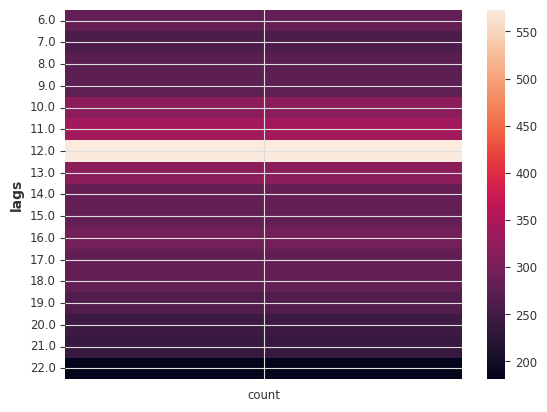

In [206]:
sns.heatmap(lags_describe[(lags_describe['is_sign'] == True) & (lags_describe['lags'] >= 6)]['lags'].value_counts().to_frame().sort_index())

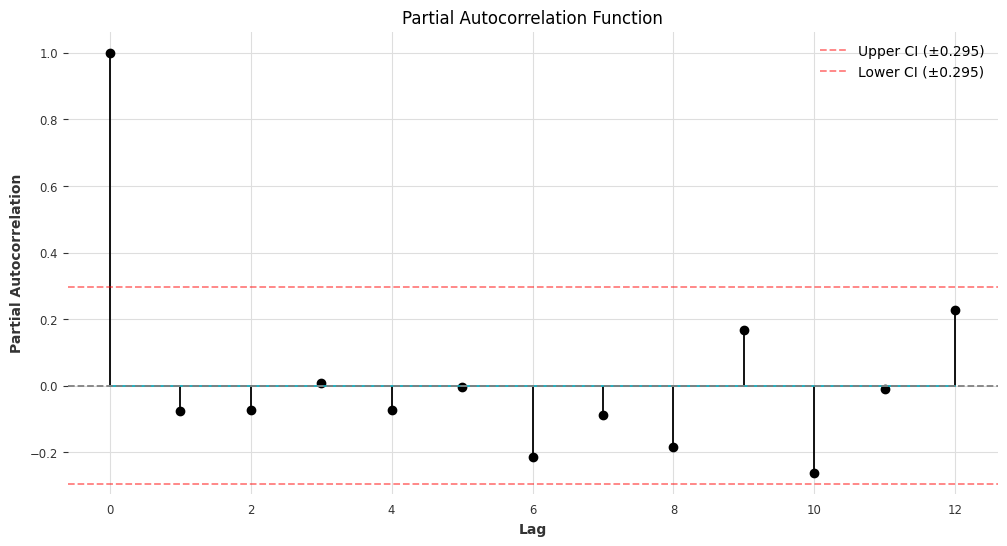

Значимые лаги (|PACF| > 0.295):
Лаг 0: 1.0000


In [373]:
# Получаем только значения PACF без доверительных интервалов
pacf_values = pacf(first_ts[['target']], nlags=12, method='ols')

# Рассчитываем доверительные интервалы как в plot_pacf
n = len(first_ts)
conf_int_manual = 1.96 / np.sqrt(n)  # ±1.96/√n

# Строим график вручную
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=conf_int_manual, linestyle='--', color='red', alpha=0.5, label=f'Upper CI (±{conf_int_manual:.3f})')
plt.axhline(y=-conf_int_manual, linestyle='--', color='red', alpha=0.5, label=f'Lower CI (±{conf_int_manual:.3f})')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.legend()
plt.show()

# Проверяем значимые лаги
significant_lags = []
for i, value in enumerate(pacf_values):
    if abs(value) > conf_int_manual:
        significant_lags.append((i, value))

print(f"Значимые лаги (|PACF| > {conf_int_manual:.3f}):")
for lag, value in significant_lags:
    print(f"Лаг {lag}: {value:.4f}")

In [374]:
second_cluster['segment'].unique()

array(['АДКМ_4 воды_4 воды Виноградная  Питьевая вода 0,75',
       'АДКМ_4 воды_4 воды Виноградная газ  Питьевая вода 0,375',
       'АДКМ_4 воды_4 воды негаз  Питьевая вода 0,375',
       'АДКМ_4 воды_4 воды негаз  Питьевая вода 0,75',
       'АДКМ_7 овощей_7 овощей  0,5',
       'АДКМ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375',
       'АДКМ_Абрау Джуниор_Абрау Джуниор Золотое  Безалкогольное шампанское 0,75',
       'АДКМ_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75',
       'АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75',
       'АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25',
       'АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс Д

In [377]:
second_cluster['segment'].unique()

array(['АДКМ_4 воды_4 воды Виноградная  Питьевая вода 0,75',
       'АДКМ_4 воды_4 воды Виноградная газ  Питьевая вода 0,375',
       'АДКМ_4 воды_4 воды негаз  Питьевая вода 0,375',
       'АДКМ_4 воды_4 воды негаз  Питьевая вода 0,75',
       'АДКМ_7 овощей_7 овощей  0,5',
       'АДКМ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375',
       'АДКМ_Абрау Джуниор_Абрау Джуниор Золотое  Безалкогольное шампанское 0,75',
       'АДКМ_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75',
       'АДКМ_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75',
       'АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,25',
       'АДКМ_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75',
       'АДКМ_Абрау Эстейтс_Абрау Эстейтс Д

In [343]:
test_outliers = second_cluster[second_cluster['segment'] == 'ТД Регион_ВВР_ВВР  Белое Сухое 0,75']

In [210]:
from darts.dataprocessing.transformers import WindowTransformer, MissingValuesFiller

filler = MissingValuesFiller()

In [344]:
ts_outliers = TimeSeries.from_dataframe(test_outliers.drop(['segment', 'cluster'], axis=1), time_col='timestamp', freq='M', fill_missing_dates=True)

ts_outliers = filler.transform(ts_outliers)

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [345]:
ts_outliers.shape

(36, 1, 1)

In [213]:
from darts.models import RegressionModel
from darts.ad.detectors import QuantileDetector, IQRDetector

In [336]:
import warnings

def stationary_transform_robust(ts):
    """
    Robust stationary transformation with fallbacks for short series.
    """
    seasonal_check = []
    
    # Определяем максимальный возможный лаг для данного ряда
    max_possible_lag = min(12, len(ts))  # ограничиваем 12 точками
    
    if len(ts) >= 8:  # минимальная длина для поиска сезонности
        for i in range(2, max_possible_lag + 1):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                seasonal_tuple = check_seasonality(ts, i, max_lag=max_possible_lag)
                if seasonal_tuple[0]:
                    seasonal_check.append(seasonal_tuple[1])
    
    # Для очень коротких рядов (< 8 точек) - только дифференцирование
    if len(ts) < 8 or not seasonal_check:
        print(f"Короткий ряд ({len(ts)} точек) или не нашлось сезонных лагов. Используем дифференцирование.")
        
        # Пробуем разность первого порядка (правильный способ для TimeSeries)
        ts_diff = ts.diff(dropna=False)
        ts_diff = filler.transform(ts_diff)  # заполняем пропуски после diff
        
        is_stationary = stationarity_tests(ts_diff)
        
        if is_stationary:
            print("Дифференцирование дало стационарный ряд")
            return ts_diff, 1, True
        else:
            # Если не стационарен, возвращаем исходный ряд
            print("Ряд нестационарен даже после дифференцирования")
            return ts, 0, False
    
    # Для рядов нормальной длины
    is_stationary = False
    stationary_ts = None
    used_lag = None
    
    for lag in sorted(seasonal_check):  # пробуем от меньшего к большему
        if lag * 2 <= len(ts):  # проверяем что хватит данных
            try:
                resids_ts = remove_trend(remove_seasonality(ts, lag))
                result = stationarity_tests(resids_ts)
                
                if result:
                    is_stationary = True
                    stationary_ts = resids_ts
                    used_lag = lag
                    print(f"Стационарность достигнута с лагом {lag}")
                    break
            except Exception as e:
                print(f"Ошибка с лагом {lag}: {e}")
                continue
    
    if not is_stationary:
        # Fallback: простое дифференцирование
        ts_diff = ts.diff(dropna=False)
        ts_diff = filler.transform(ts_diff)
        is_stationary_diff = stationarity_tests(ts_diff)
        print(f"Сезонные методы не сработали. Используем дифференцирование.")
        return ts_diff, 1, is_stationary_diff
    
    return stationary_ts, used_lag, is_stationary

In [341]:
df['segment'].nunique()

4079

In [374]:
def outlier_detector(ts, detector):
    ts = filler.transform(ts)
    stationary_ts, _, _ = stationary_transform_robust(ts)
    detector.fit(stationary_ts)
    anomalies = detector.detect(stationary_ts)
    return anomalies

In [380]:
def manual_interpolate_series(ts, anomaly, method='linear'):
    """
    Полный пайплайн: удаление аномалий + интерполяция
    """
    # 1. Извлекаем данные
    values = ts.values().copy()
    anomaly_flags = anomaly.values().flatten()
    
    print(f"Всего точек: {len(values)}")
    print(f"Найдено аномалий: {np.sum(anomaly_flags)}")
    
    # 2. Создаем копию и заменяем аномалии на NaN
    cleaned_values = values.copy()
    cleaned_values[anomaly_flags == 1] = np.nan
    
    # 3. Интерполяция вручную через pandas
    time_index = ts.time_index
    df = pd.DataFrame({
        'values': cleaned_values.flatten(),
        'timestamp': time_index
    })
    df = df.set_index('timestamp')
    
    # Применяем интерполяцию
    if method == 'linear':
        df['filled'] = df['values'].interpolate(method='linear')
    elif method == 'time':
        df['filled'] = df['values'].interpolate(method='time')
    elif method == 'nearest':
        df['filled'] = df['values'].interpolate(method='nearest')
    elif method == 'cubic':
        df['filled'] = df['values'].interpolate(method='cubic')
    elif method == 'spline':
        df['filled'] = df['values'].interpolate(method='spline', order=3)
    elif method == 'ffill':
        df['filled'] = df['values'].ffill()
    elif method == 'bfill':
        df['filled'] = df['values'].bfill()
    elif method == 'mean':
        mean_val = np.nanmean(df['values'])
        df['filled'] = df['values'].fillna(mean_val)
    else:
        df['filled'] = df['values'].interpolate(method='linear')
    
    # 4. Создаем новые TimeSeries
    cleaned_series = TimeSeries.from_times_and_values(
        times=time_index,
        values=cleaned_values,
        columns=ts.columns,
        freq=ts.freq
    )
    
    filled_series = TimeSeries.from_times_and_values(
        times=time_index,
        values=df['filled'].values.reshape(-1, 1),
        columns=[f"{col}_filled" for col in ts.columns],
        freq=ts.freq
    )
    
    return cleaned_series, filled_series


In [ ]:
def outlier_pruner(ts, anomalies, show_plot=False, method='linear'):
    _, interpolated = manual_interpolate_series(ts, anomalies, method=method)

    if show_plot:
        timestamp_anomaly = anomalies.to_series()[anomalies.to_series() == 1].index
        # Даты для подсветки
        highlight_dates = timestamp_anomaly

        # Строим график и получаем ось
        fig, ax = plt.subplots()
        ts.plot(ax=ax)

        # Подсвечиваем все нужные даты
        for date in highlight_dates:
            highlight_value = ts[date].values()[0]  # извлекаем скалярное значение
            ax.scatter(date, highlight_value, color='red', s=20, zorder=5)
        plt.title('Исходный временной ряд с аномалиями')
        plt.show()

        # Строим график и получаем ось
        fig, ax = plt.subplots()
        interpolated.plot(ax=ax)

        # Подсвечиваем все нужные даты
        for date in highlight_dates:
            highlight_value = interpolated[date].values()[0]  # извлекаем скалярное значение
            ax.scatter(date, highlight_value, color='red', s=20, zorder=5)
        plt.title('Исходный временной ряд с аномалиями')
        plt.show()

    return  interpolated

In [410]:
def outlier_pruner(ts, anomalies, show_plot=False, method='linear'):
    """
    Remove outliers from time series and interpolate missing values.
    
    Parameters
    ----------
    ts : TimeSeries
        Input time series
    anomalies : TimeSeries
        Binary series indicating anomalies (1 = anomaly)
    show_plot : bool
        Whether to show before/after plots
    method : str
        Interpolation method
    
    Returns
    -------
    TimeSeries
        Series with outliers removed and interpolated
    """
    
    # Проверка входных данных
    if len(ts) != len(anomalies):
        raise ValueError("Длины ts и anomalies должны совпадать")
    
    # Интерполяция аномалий
    _, interpolated = manual_interpolate_series(ts, anomalies, method=method)

    interpolated = filler.transform(interpolated)

    if show_plot:
        try:
            # Получаем даты аномалий
            anomaly_series = anomalies.to_series()
            timestamp_anomaly = anomaly_series[anomaly_series == 1].index
            highlight_dates = timestamp_anomaly
            
            # Создаем графики
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Функция для безопасного извлечения значений
            def safe_get_value(series, date):
                try:
                    point = series[date]
                    # Универсальный способ получения значения
                    if hasattr(point, 'univariate_values'):
                        return point.univariate_values()[0]
                    elif hasattr(point, 'values') and callable(point.values):
                        return point.values()[0]
                    else:
                        return point.values[0]
                except (IndexError, KeyError, AttributeError):
                    return None
            
            # График 1: Исходный ряд
            ts.plot(ax=ax1, label='Исходный ряд', color='blue', alpha=0.7)
            anomaly_values = []
            anomaly_dates = []
            
            for date in highlight_dates:
                value = safe_get_value(ts, date)
                if value is not None:
                    anomaly_values.append(value)
                    anomaly_dates.append(date)
            
            if anomaly_dates:
                ax1.scatter(anomaly_dates, anomaly_values, color='red', s=40, 
                           zorder=5, label=f'Аномалии ({len(anomaly_dates)})')
            
            ax1.set_title('Исходный временной ряд с аномалиями')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # График 2: Интерполированный ряд
            interpolated.plot(ax=ax2, label='Интерполированный ряд', color='green', alpha=0.7)
            interpolated_values = []
            
            for date in highlight_dates:
                value = safe_get_value(interpolated, date)
                if value is not None:
                    interpolated_values.append(value)
            
            if anomaly_dates and interpolated_values:
                ax2.scatter(anomaly_dates, interpolated_values, color='red', s=40, 
                           zorder=5, label='Замененные точки')
            
            ax2.set_title('Ряд после обработки аномалий')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Ошибка при построении графиков: {e}")
            # Показываем простой график в случае ошибки
            plt.figure(figsize=(12, 6))
            ts.plot(label='Исходный')
            interpolated.plot(label='Интерполированный')
            plt.legend()
            plt.title('Сравнение исходного и интерполированного рядов')
            plt.show()

    return interpolated

Всего точек: 24
Найдено аномалий: 4.0


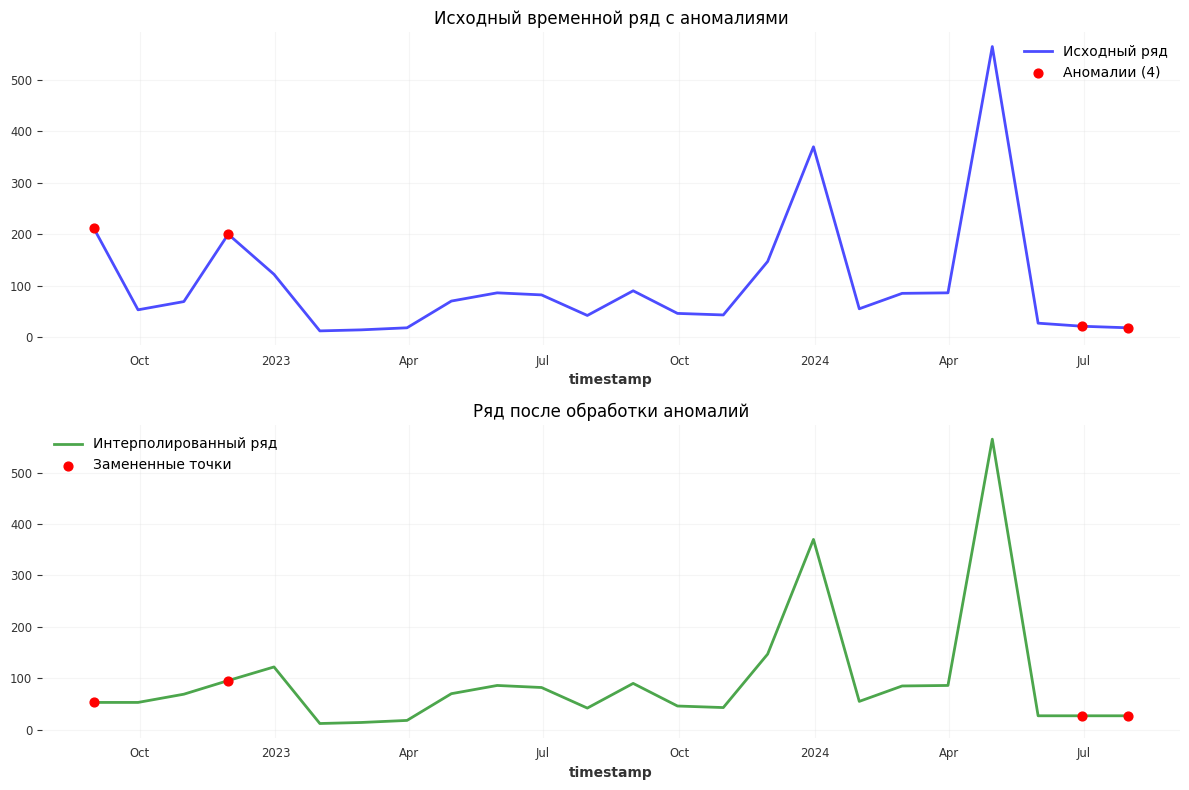

<TimeSeries (timestamp: 24, component: 1, sample: 1)> Size: 192B
array([[[ 53. ]],

       [[ 53. ]],

       [[ 69. ]],

       [[ 95.5]],

       [[122. ]],

       [[ 12. ]],

       [[ 14. ]],

       [[ 18. ]],

       [[ 70. ]],

       [[ 86. ]],

...

       [[ 43. ]],

       [[147. ]],

       [[370. ]],

       [[ 55. ]],

       [[ 85. ]],

       [[ 86. ]],

       [[565. ]],

       [[ 27. ]],

       [[ 27. ]],

       [[ 27. ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 192B 2022-08-31 ... 2024-07-31
  * component  (component) object 8B 'target_filled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [413]:
outlier_pruner(ts_outliers, anomalies, show_plot=True)